In [49]:
import numpy as np
import matplotlib.pyplot as plt
import os, glob

import sys
sys.path.append('../')
import analysis_utils as utils
utils.load_plotting_setting()

from scipy.special import erf
from scipy.signal import welch

In [154]:
import importlib
importlib.reload(utils)

<module 'analysis_utils' from '/Users/yuhan/work/nanospheres/gas_collisiions/analyss_notebooks/../analysis_utils.py'>

#### Calibrate the displacement noise and integrate over force noise

In [77]:
_files = [r'/Volumes/LaCie/gas_collisions/pulse_calibration/sphere_20250908/20250910_electric_calibration_5e-8mbar_0/20250910_d_p10e_73khz_10vpp_0.hdf5',
         r'/Volumes/LaCie/gas_collisions/pulse_calibration/sphere_20250908/20250910_electric_calibration_5e-8mbar_0/20250910_d_p10e_73khz_10vpp_1.hdf5',
         r'/Volumes/LaCie/gas_collisions/pulse_calibration/sphere_20250908/20250910_electric_calibration_5e-8mbar_0/20250910_d_p10e_73khz_10vpp_2.hdf5',
         r'/Volumes/LaCie/gas_collisions/pulse_calibration/sphere_20250908/20250910_electric_calibration_5e-8mbar_0/20250910_d_p10e_73khz_10vpp_3.hdf5',
         r'/Volumes/LaCie/gas_collisions/pulse_calibration/sphere_20250908/20250910_electric_calibration_5e-8mbar_0/20250910_d_p10e_73khz_10vpp_4.hdf5']

c_mvs = utils.get_c_mv(_files, vp2p=[10,10,10,10,10], omegad=73000*2*np.pi, passband=(72700, 73300), searchband=(25000, 40000), charge=10, n_chunk=1, efield=79)
c_mv = np.mean(c_mvs)

print(f'c_mv: {c_mv}')

c_mv: 4.310914419984533e-07


In [142]:
_file = r'/Volumes/LaCie/gas_collisions/pulse_calibration/sphere_20250908/20250910_electric_calibration_5e-8mbar_0/20250910_d_p10e_nodrive_4.hdf5'
ff, sz_measured, sf_measured, chi_2_convolved, dp_kev = utils.get_effective_force_noise(_file, c_mv, int_band=(20000, 70000), fit_band=(29000, 32000), nperseg=2**17)
print(f'Delta_p: {dp_kev} keV/c')

# Get the imprecision noise floor
_idx = np.logical_and(ff>100000, ff<120000)
sz_imp = np.mean(sz_measured[_idx])
sf_imp = sz_imp / chi_2_convolved

# Estimated contribution of backaction
sf_ba_th = 1.444e-40 * (3/5)**2
sz_ba_th = sf_ba_th * chi_2_convolved

# Estimated thermal noise
sf_th = 8.86666278161278e-42 * 5/2
sz_th = sf_th * chi_2_convolved

Delta_p: 120.2192366413752 keV/c


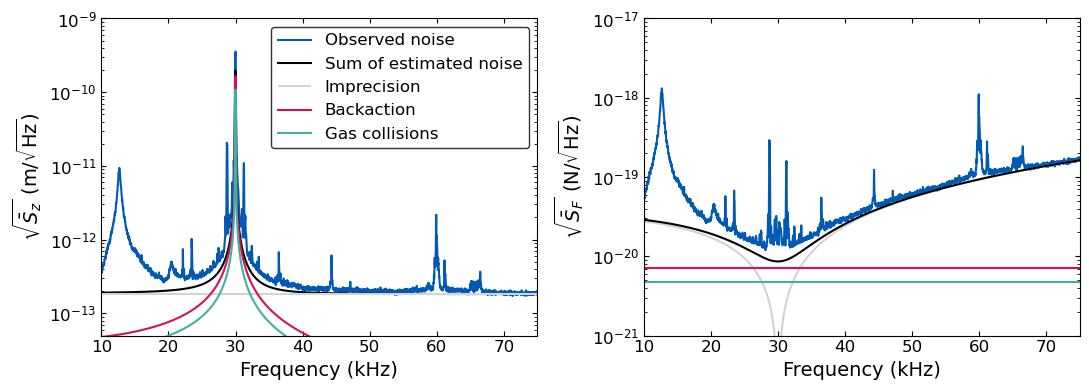

In [122]:

fig, axes = plt.subplots(1, 2, figsize=(11, 4))
axes[0].plot(ff/1000, np.sqrt(sz_measured), color='#005AB5', label='Observed noise')
axes[0].plot(ff/1000, np.sqrt(sz_imp + sz_ba_th + sz_th), color='k', label='Sum of estimated noise')
axes[0].hlines(np.sqrt(sz_imp), 10, 75, linestyle='-', color='lightgrey', label='Imprecision')
axes[0].plot(ff/1000, np.sqrt(sz_ba_th), color='#D41159', label='Backaction')
axes[0].plot(ff/1000, np.sqrt(sz_th), color='#40B0A6', label='Gas collisions')

axes[1].plot(ff/1000, np.sqrt(sf_measured), color='#005AB5')
axes[1].plot(ff/1000, np.sqrt(sf_imp), color='lightgrey')
axes[1].hlines(np.sqrt(sf_ba_th), 10, 75, linestyle='-', color='#D41159')
axes[1].hlines(np.sqrt(sf_th), 10, 75, linestyle='-', color='#40B0A6')
axes[1].plot(ff/1000, np.sqrt(sf_imp + sf_ba_th + sf_th), color='k')

for ax in axes:
    ax.set_yscale('log')
    ax.set_xlim(10, 75)
    ax.set_xlabel('Frequency (kHz)')
axes[0].legend(edgecolor='k')
axes[0].set_ylabel(r'$\sqrt{\bar{S}_{z}}$ (m/$\sqrt{\mathrm{Hz}}$)')
axes[1].set_ylabel(r'$\sqrt{\bar{S}_{F}}$ (N/$\sqrt{\mathrm{Hz}}$)')

axes[0].set_ylim(5e-14, 1e-9)
axes[1].set_ylim(1e-21, 1e-17)

fig.align_labels()
fig.tight_layout()

/var/folders/mb/1ggr_wms5jz0l7fkkc3b9xg80000gn/T/ipykernel_1855/2039611341.py:3: RuntimeWarning: invalid value encountered in sqrt
  plt.plot(ff/1000, np.sqrt(sf_measured - sf_imp - sf_ba_th - sf_th) / np.sqrt(sf_measured), 'b')


Text(0, 0.5, '$\\sqrt{\\Delta \\bar{S}_{F} ~/~ \\bar{S}_{F}}$ (a. u.)')

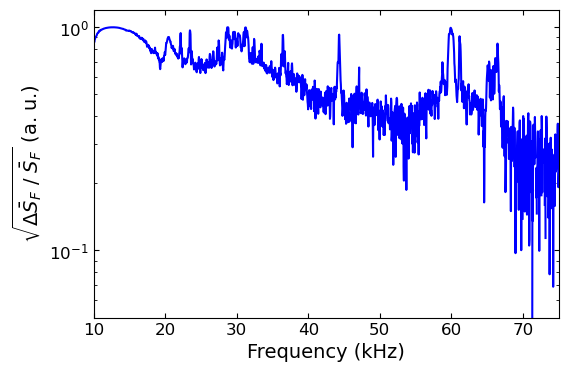

In [143]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

plt.plot(ff/1000, np.sqrt(sf_measured - sf_imp - sf_ba_th - sf_th) / np.sqrt(sf_measured), 'b')
plt.yscale('log')
plt.xlim(10, 75)
plt.ylim(5e-2, 1.2)

plt.xlabel('Frequency (kHz)')
plt.ylabel(r'$\sqrt{\Delta \bar{S}_{F} ~/~ \bar{S}_{F}}$ (a. u.)')

#### Reconstruction using the old code

In [146]:
data_folder = r'/Volumes/LaCie/gas_collisions/pulse_calibration/sphere_20250908/20250910_p10e_5e-8mbar_30khz_d93khz_0'
data_prefix = '20250910_dfg_p10e_200ns_'
voltages = [5, 10, 15, 20]

amps_all = []
amps_noise = None
for i, v in enumerate(voltages):
    print(v)
    dataset = data_prefix + f'{v}v'
    combined_path = os.path.join(data_folder, f'{dataset}*.hdf5')
    data_files = glob.glob(combined_path)

    amps = utils.get_unnormalized_amps(data_files, 
                            noise=False,
                            no_search=False,
                            positive_pulse=True,
                            notch_freq=93000,
                            passband=(20000, 50000),
                            analysis_window_length=50000,
                            prepulse_window_length=50000,
                            search_window_length=250,
                            search_offset_length=20,
                            lowpass_freq=50000
                            )

    if v == 5:
        amps_noise = utils.get_unnormalized_amps(data_files, 
                        noise=True,
                        no_search=True,
                        positive_pulse=True,
                        notch_freq=93000,
                        passband=(20000, 50000),
                        analysis_window_length=50000,
                        prepulse_window_length=50000,
                        search_window_length=250,
                        search_offset_length=20,
                        lowpass_freq=50000
                        )
            
    amps_all.append(np.asarray(amps))

5
Skipping pulse too close to the beginning of file
10
15
Skipping pulse too close to the beginning of file
20


In [155]:
pulse_amps_1e = np.asarray([34, 80, 127, 174])
pulse_amp = pulse_amps_1e * 10

bins = np.arange(0,3000, 50) / 61721.2989069973
hhs, bcs, gps = utils.fit_amps_gaus(amps_all, bins=bins, noise=False, return_bins=False)
hhs_noise, bcs_noise, gps_noise = utils.fit_amps_gaus([amps_noise], bins=bins, noise=True, return_bins=False)

amp2kevs = pulse_amp / np.asarray(gps).T[1]
amp2kev_all = amp2kevs[-1]

Text(0, 0.5, 'Counts/(50 keV/$c$)')

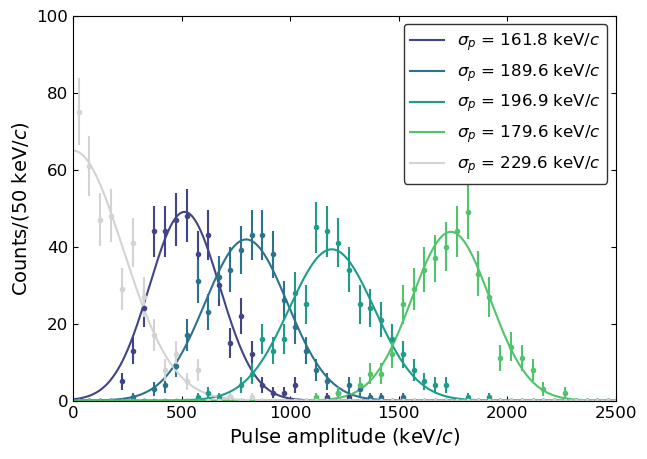

In [158]:
plt.figure(figsize=(7, 5))
xx = np.linspace(0, np.max(bcs[0]), 1000)

cmap = plt.colormaps.get_cmap('viridis')
colors = cmap(np.linspace(0.2, 0.9, 5))
for i in range(4):
    plt.errorbar(bcs[i]*amp2kev_all, hhs[i], yerr=np.sqrt(hhs[i]), fmt='.', color=colors[i])
    plt.plot(xx*amp2kev_all, utils.gauss(xx, *gps[i]), label=fr'$\sigma_p$ = {gps[i][2]*amp2kev_all:.1f} keV/$c$', color=colors[i])

plt.errorbar(bcs_noise[0]*amp2kev_all, hhs_noise[0], yerr=np.sqrt(hhs_noise[0]), fmt='.', color='lightgrey')
plt.plot(xx*amp2kev_all, utils.gauss_zero(xx, *gps_noise[0]), label=fr'$\sigma_p$ = {gps_noise[0][1]*amp2kev_all:.1f} keV/$c$', color='lightgrey')

plt.xlim(0, 2500)
plt.ylim(0, 100)
plt.legend(edgecolor='k')
plt.xlabel(r'Pulse amplitude (keV/$c$)')
plt.ylabel(r'Counts/(50 keV/$c$)')